# Project 3


# Movie Genre Classification

Classify a movie genre based on its plot.

<img src="moviegenre.png"
     style="float: left; margin-right: 10px;" />




https://www.kaggle.com/c/miia4201-202019-p3-moviegenreclassification/overview

### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 20% API
- 30% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 50% Performance in the Kaggle competition (The grade for each group will be proportional to the ranking it occupies in the competition. The group in the first place will obtain 5 points, for each position below, 0.25 points will be subtracted, that is: first place: 5 points, second: 4.75 points, third place: 4.50 points ... eleventh place: 2.50 points, twelfth place: 2.25 points).

• The project must be carried out in the groups assigned for module 4.
• Use clear and rigorous procedures.
• The delivery of the project is on July 12, 2020, 11:59 pm, through Sicua + (Upload: the API and the report in PDF format).
• No projects will be received after the delivery time or by any other means than the one established. 




### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

## Configuraciones Iniciales

In [30]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
from nltk  import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,  ExtraTreesClassifier
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score, make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV,train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegressionCV
import tensorflow as tf
tf.device("gpu:0")
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import Callback, EarlyStopping
from livelossplot import PlotLossesKeras

In [31]:
dataTraining = pd.read_csv('datasets/dataTraining.csv', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('datasets/dataTesting.csv', encoding='UTF-8', index_col=0)

In [32]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [33]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


### Create count vectorizer

In [34]:
#cargamos los stopwords
nltk.download('stopwords')
#guardamos los stopwords
e_stp = stopwords.words('english')
#guardamos los signos de puntuacion
signos = string.punctuation

#Convertimos los plots en una sola lista
X = dataTraining['plot'].to_list()
#Convertimos todo en minúsculas
X = [x.lower() for x in X]
X = [''.join(c for c in s if c not in string.punctuation) for s in X]
#Unimos todas las filas y separamos por espacio cada palabra
X2 = ''.join(X).split() 
#removemos las palabras repetidas
X2 = set(X2) 
#quitamos los stopswords que coincidan con nuestra base de stopwords
X2 = [x for x in X2 if x not in e_stp]
#Creamos el vocabulario
voc = {x: idx + 1 for idx, x in enumerate(X2)}

#creamos el array longitud vacío para ir agregando la cantidad de palabras por plot
longitud =[]
#creamos el for que recorra todos los plot
for i in range(0,len(dataTraining['plot'])):
    #agregamos a longitud el largo de cada plot (partido por palabras)
    longitud.append(len(dataTraining['plot'].to_list()[i].split()))
#revisamos los descriptivos acá, sobre todo para revisar los percentiles y tomar el P99 como nuestro max length del pad
pd.DataFrame(longitud).describe(percentiles = [0.90,0.95,0.975,0.99])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,0
count,7895.000000
mean,144.770868
std,95.816408
min,1.000000
50%,127.000000
90%,274.600000
95%,328.000000
97.5%,379.650000
99%,438.060000
max,1863.000000


In [35]:
len_pad = 438
#Creamos un split con todas las palabras 
X_ = [x.split()[:len_pad] for x in X]
#Cambiamos las palabras por el valor int de esa palabra creado en el diccionario vocabulario
X_ = [[voc[x1] for x1 in x if x1 in voc.keys()] for x in X_]
#Creamos el PAD
X_pad = sequence.pad_sequences(X_, maxlen=len_pad)
tf.keras.backend.clear_session()

In [36]:
X_pad = (X_pad)/50000


### Create y

In [37]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [38]:
y_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [39]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_pad, y_genres, test_size=0.66, random_state=666)

### Train multi-class multi-label model

In [40]:
%matplotlib inline

In [47]:
def auc_2(y_true, y_pred):
    return tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double)

In [48]:
tf.keras.backend.clear_session()
model = Sequential(name="NLP - LSTM Genre Prediction ")
model.add(Embedding(len_pad+1, 200, input_length=X_train.shape[1]))
model.add(LSTM(200))
model.add(Dropout(0.5))
model.add(Dense(y_train_genres.shape[1], activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='Adagrad', metrics=[auc_2])
#model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[tf.keras.metrics.AUC(multi_label=True)])
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=["accuracy"])
model.summary()

Model: "NLP - LSTM Genre Prediction "
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 438, 200)          87800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                4824      
Total params: 413,424
Trainable params: 413,424
Non-trainable params: 0
_________________________________________________________________


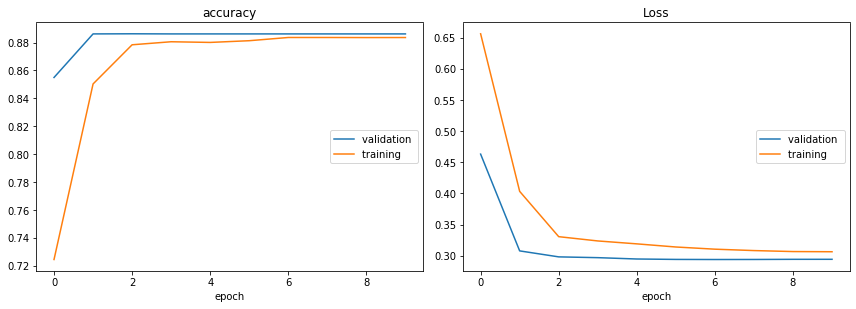

accuracy
	validation       	 (min:    0.855, max:    0.886, cur:    0.886)
	training         	 (min:    0.724, max:    0.884, cur:    0.884)
Loss
	validation       	 (min:    0.294, max:    0.463, cur:    0.294)
	training         	 (min:    0.306, max:    0.656, cur:    0.306)


In [49]:
model.fit(X_train, y_train_genres, validation_data=[X_test, y_test_genres], 
        epochs=10, verbose=1, batch_size=512,
          callbacks=[PlotLossesKeras()])

In [50]:
y_pred_genres = model.predict_proba(X_test)

In [66]:
X_test

array([[0.     , 0.     , 0.     , ..., 0.4446 , 0.26648, 0.38864],
       [0.     , 0.     , 0.     , ..., 0.34612, 0.05842, 0.35474],
       [0.     , 0.     , 0.     , ..., 0.40842, 0.70826, 0.36824],
       ...,
       [0.     , 0.     , 0.     , ..., 0.2509 , 0.26144, 0.07082],
       [0.     , 0.     , 0.     , ..., 0.4591 , 0.4446 , 0.06098],
       [0.     , 0.     , 0.     , ..., 0.16656, 0.15848, 0.31464]])

In [55]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.5

### Predict the testing dataset

In [154]:
X9 = dataTesting['plot'].to_list()
#Convertimos todo en minúsculas
X9 = [x.lower() for x in X9]
X9 = [''.join(c for c in s if c not in string.punctuation) for s in X9]

X8 = [x.split()[:len_pad] for x in X9]
#Cambiamos las palabras por el valor int de esa palabra creado en el diccionario vocabulario
X8 = [[voc[x1] for x1 in x if x1 in voc.keys()] for x in X8]
#Creamos el PAD
X_pad2 = sequence.pad_sequences(X8, maxlen=len_pad)




In [156]:
X_pad2 = (X_pad2+5000)/50000
X_pad2

array([[0.100002  , 0.100002  , 0.100002  , ..., 0.10000685, 0.10001077,
        0.10001326],
       [0.100002  , 0.100002  , 0.100002  , ..., 0.10001112, 0.10001113,
        0.10001607],
       [0.100002  , 0.100002  , 0.100002  , ..., 0.10001343, 0.10000787,
        0.10000312],
       ...,
       [0.100002  , 0.100002  , 0.100002  , ..., 0.10000414, 0.10001688,
        0.10000942],
       [0.100002  , 0.100002  , 0.100002  , ..., 0.10000227, 0.10001719,
        0.10001163],
       [0.100002  , 0.100002  , 0.100002  , ..., 0.10000577, 0.10000539,
        0.10001248]])

In [157]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model.predict_proba(X_pad2)

In [158]:
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [159]:
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.173973,0.14711,0.036689,0.046988,0.396658,0.196399,0.052938,0.525232,0.090564,0.099127,...,0.041329,0.086445,0.005835,0.264969,0.085403,0.016008,0.039167,0.229333,0.042071,0.03236
4,0.173973,0.14711,0.036689,0.046988,0.396658,0.196399,0.052938,0.525232,0.090564,0.099127,...,0.041329,0.086445,0.005835,0.264969,0.085403,0.016008,0.039167,0.229333,0.042071,0.03236
5,0.173973,0.14711,0.036689,0.046988,0.396658,0.196399,0.052938,0.525232,0.090564,0.099127,...,0.041329,0.086445,0.005835,0.264969,0.085403,0.016008,0.039167,0.229333,0.042071,0.03236
6,0.173973,0.14711,0.036689,0.046988,0.396658,0.196399,0.052938,0.525232,0.090564,0.099127,...,0.041329,0.086445,0.005835,0.264969,0.085403,0.016008,0.039167,0.229333,0.042071,0.03236
7,0.173973,0.14711,0.036689,0.046988,0.396658,0.196399,0.052938,0.525232,0.090564,0.099127,...,0.041329,0.086445,0.005835,0.264969,0.085403,0.016008,0.039167,0.229333,0.042071,0.03236


In [ ]:
res.to_csv('pred_genres_text_RF.csv', index_label='ID')

In [160]:
X_pad2

array([[0.100002  , 0.100002  , 0.100002  , ..., 0.10000685, 0.10001077,
        0.10001326],
       [0.100002  , 0.100002  , 0.100002  , ..., 0.10001112, 0.10001113,
        0.10001607],
       [0.100002  , 0.100002  , 0.100002  , ..., 0.10001343, 0.10000787,
        0.10000312],
       ...,
       [0.100002  , 0.100002  , 0.100002  , ..., 0.10000414, 0.10001688,
        0.10000942],
       [0.100002  , 0.100002  , 0.100002  , ..., 0.10000227, 0.10001719,
        0.10001163],
       [0.100002  , 0.100002  , 0.100002  , ..., 0.10000577, 0.10000539,
        0.10001248]])

In [228]:
X9 = dataTesting['plot'].to_list()
#Convertimos todo en minúsculas
X9 = [x.lower() for x in X9]
X9 = [''.join(c for c in s if c not in string.punctuation) for s in X9]
#X9 = [word_tokenize(i) for i in X9]
#x8 = [[word for word in X9[x] if not word in e_stp] for x in range(0,len(X9))]
#X9 = [x for x in X9 if x in e_stp]

X8 = [x.split()[:len_pad] for x in X9]
#cambiamos las palabras por el valor int de esa palabra creado en el diccionario vocabulario
X8 = [[voc[x1] for x1 in x if x1 in voc.keys()] for x in X8]
#Creamos el PAD
X_pad2 = (sequence.pad_sequences(X8, maxlen=len_pad))/50000
X_pad2

array([[0.     , 0.     , 0.     , ..., 0.2427 , 0.43874, 0.56278],
       [0.     , 0.     , 0.     , ..., 0.45594, 0.45652, 0.7036 ],
       [0.     , 0.     , 0.     , ..., 0.57136, 0.29344, 0.05602],
       ...,
       [0.     , 0.     , 0.     , ..., 0.1071 , 0.74382, 0.37094],
       [0.     , 0.     , 0.     , ..., 0.0135 , 0.7597 , 0.48148],
       [0.     , 0.     , 0.     , ..., 0.18866, 0.1696 , 0.5239 ]])

In [222]:
list(range(0,len(X8)))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
